<a href="https://colab.research.google.com/github/ssrinivas-berkeley/genai-playground/blob/main/Emoji_Trailer_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🎬 Emoji → Movie Trailer (Colab, compat‑fixed)

Turn a title + 5–7 emojis into a 20–30s **movie trailer**: storyboard frames, AI voiceover, captions, SFX/BGM, and a poster — all in this one notebook.

**How to use**  
1) Run **Setup** → 2) Run **Build Pipeline** → 3) Set params in **Run Demo** and execute.  
Outputs are saved to `results/` and previewed inline.


## 🛠️ Setup

In [1]:

# Install/upgrade deps. tqdm>=4.67 is required by some Colab packages.
!pip -q install --upgrade moviepy==1.0.3 Pillow==10.4.0 numpy==2.0.2 gTTS tqdm>=4.67 imageio-ffmpeg

import os, wave, contextlib
from pathlib import Path

# Folders
RESULTS = Path("results"); FRAMES = RESULTS / "frames"
RESULTS.mkdir(exist_ok=True, parents=True); FRAMES.mkdir(exist_ok=True, parents=True)

print("✅ Dependencies installed. Folders ready at", RESULTS.resolve())


✅ Dependencies installed. Folders ready at /content/results


## 🧰 Pillow compatibility shim (textsize → textbbox)

In [2]:

# Pillow 10+ removed ImageDraw.textsize. Provide a shim that maps to textbbox measurements.
from PIL import ImageDraw as _ID

def _compat_textsize(self, text, font=None, *args, **kwargs):
    # Returns (w, h) using textbbox
    bbox = self.textbbox((0,0), text, font=font, *args, **kwargs)
    return (bbox[2]-bbox[0], bbox[3]-bbox[1])

if not hasattr(_ID.ImageDraw, "textsize"):
    _ID.ImageDraw.textsize = _compat_textsize  # type: ignore[attr-defined]

print("✅ Pillow textsize shim active")


✅ Pillow textsize shim active


## 🧱 Build Pipeline (utils)

In [3]:

from typing import List, Tuple
import numpy as np
import wave, contextlib

def split_sentences(text: str):
    import re
    parts = re.split(r'(?<=[.!?])\s+', text.strip())
    return [p for p in parts if p]

def alloc_durations(total_s: float, sentences: List[str]) -> List[Tuple[str, float]]:
    weights = [max(5, len(s)) for s in sentences]  # avoid zero
    total_w = sum(weights) if sum(weights) else 1
    return [(s, total_s * (w/total_w)) for s, w in zip(sentences, weights)]

def seconds_to_srt(ts: float) -> str:
    h = int(ts // 3600); ts -= h*3600
    m = int(ts // 60);   ts -= m*60
    s = int(ts);         ms = int((ts - s) * 1000)
    return f"{h:02}:{m:02}:{s:02},{ms:03}"

def save_wav_from_array(path: str, sr: int, data: np.ndarray):
    data16 = np.int16(np.clip(data, -1.0, 1.0) * 32767)
    with wave.open(path, 'wb') as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sr)
        wf.writeframes(data16.tobytes())

print("✅ Utils loaded")


✅ Utils loaded


## 🧠 Script generation

In [4]:

from dataclasses import dataclass

STYLE_CARDS = {
    "noir":  {"palette": ["#0b0b0b", "#e5e5e5"], "tone":"gritty", "camera":["close-up","low-angle","silhouette"]},
    "anime": {"palette": ["#111122", "#ff4d6d", "#2ec4b6"], "tone":"epic", "camera":["wide","dynamic","over-shoulder"]},
    "vhs":   {"palette": ["#0f0f1a", "#b2f7ef", "#f7d6e0"], "tone":"retro", "camera":["medium","zoom","handheld"]},
}

EMOJI_HINTS = {
    "🤖":{"topic":"AI","mood":"tech"}, "🔥":{"topic":"action","mood":"intense"},
    "🎭":{"topic":"drama","mood":"serious"}, "🌃":{"topic":"city","mood":"nocturnal"},
    "💎":{"topic":"heist","mood":"slick"}, "🧠":{"topic":"mind","mood":"clever"},
    "🚀":{"topic":"space","mood":"adventure"}, "🌊":{"topic":"ocean","mood":"calm"},
    "⚡️":{"topic":"power","mood":"charged"}, "🍜":{"topic":"food","mood":"comfort"},
}

@dataclass
class Beat:
    title: str
    narration: str
    line: str
    mood: str

@dataclass
class TrailerPlan:
    beats: List[Beat]
    style: str
    palette: list

def _emoji_topics(emojis: List[str]) -> List[str]:
    topics = []
    for e in emojis:
        if e in EMOJI_HINTS:
            topics.append(EMOJI_HINTS[e]["topic"])
    return topics or ["mystery"]

def _dominant_mood(emojis: List[str]) -> str:
    moods = [EMOJI_HINTS[e]["mood"] for e in emojis if e in EMOJI_HINTS]
    return moods[0] if moods else "epic"

def generate_trailer_plan(title: str, emojis: List[str], style: str="anime") -> TrailerPlan:
    topics = _emoji_topics(emojis)
    mood = _dominant_mood(emojis)
    style_card = STYLE_CARDS.get(style, STYLE_CARDS["anime"])
    tone = style_card["tone"]

    outline = [
        ("Hook",          f"In a world of {', '.join(topics[:2])}...",            "CHAR A: I wasn't ready for this."),
        ("World",         f"Neon streets hum, secrets simmer beneath.",           "CHAR B: You hear that? It's starting."),
        ("Conflict",      f"But when fate collides with {topics[-1]}...",         "CHAR A: We either run—or rewrite the rules."),
        ("Escalation",    f"Chases, whispers, and a countdown ticking to zero.",  "CHAR B: On my mark. Three... two..."),
        ("Twist",         f"The truth is not what it seems—it's louder.",         "CHAR A: We were the signal all along."),
        ("Call-To-Action",f"This {tone} story hits now.",                          "NARRATOR: This is just the trailer."),
    ]

    beats = [Beat(bt, narr, line, mood) for bt, narr, line in outline]
    return TrailerPlan(beats=beats, style=style, palette=style_card["palette"])

print("✅ Script generator ready")


✅ Script generator ready


## 🎬 Prompt composition (shots)

In [5]:

from dataclasses import dataclass
import random

CAMERA = {
    "close-up": {"zoom":1.1, "pan":0.0},
    "wide":     {"zoom":1.0, "pan":0.05},
    "low-angle":{"zoom":1.05,"pan":0.02},
    "dynamic":  {"zoom":1.12,"pan":0.06},
    "over-shoulder":{"zoom":1.03,"pan":0.03},
    "zoom":     {"zoom":1.15,"pan":0.0},
    "handheld": {"zoom":1.08,"pan":0.04},
    "medium":   {"zoom":1.02,"pan":0.02},
    "silhouette":{"zoom":1.0, "pan":0.03},
}

@dataclass
class Shot:
    text: str
    camera: str
    zoom: float
    pan: float
    color: str

def compose_shots(plan, style_card_cameras: list[str]=None) -> list[Shot]:
    cams = style_card_cameras or ["wide","close-up","dynamic","medium","low-angle","zoom"]
    shots = []
    palette = plan.palette
    for i, beat in enumerate(plan.beats):
        cam = random.choice(cams)
        z, p = CAMERA[cam]["zoom"], CAMERA[cam]["pan"]
        color = palette[i % len(palette)]
        text = f"{beat.title}: {beat.narration}"
        shots.append(Shot(text=text, camera=cam, zoom=z, pan=p, color=color))
    return shots

print("✅ Prompt composer ready")


✅ Prompt composer ready


## 🖼️ Procedural image generation (Pillow)

In [6]:

from PIL import Image, ImageDraw, ImageFont, ImageFilter

def _vignette(img: Image.Image):
    w, h = img.size
    mask = Image.new('L', (w, h), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((-int(.2*w), -int(.2*h), int(1.2*w), int(1.2*h)), fill=255)
    mask = mask.filter(ImageFilter.GaussianBlur(radius=int(min(w,h)*0.08)))
    black = Image.new('RGB', (w,h), (0,0,0))
    return Image.composite(img, black, mask)

def _draw_text(img, text, color, pos):
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 32)
    except:
        font = ImageFont.load_default()
    draw.text(pos, text, fill=color, font=font)
    return img

def generate_images(shots, outdir: Path, size=(1280, 720)) -> list[Path]:
    outpaths = []
    for i, shot in enumerate(shots):
        img = Image.new('RGB', size, shot.color)
        # subtle gradient stripes
        stripe_color = tuple(int(int(shot.color.strip("#")[j:j+2],16)*0.8) for j in (0,2,4))
        stripe = Image.new('RGB', (size[0], 10), stripe_color)
        for y in range(0, size[1], 20):
            img.paste(stripe, (0, y))
        img = _vignette(img)

        cue = f"🎥 {shot.camera}  🔍x{shot.zoom:.2f}  ↔ {shot.pan:.2f}"
        img = _draw_text(img, cue, (255,255,255), (40, size[1]-80))
        img = _draw_text(img, (shot.text[:70] + ("..." if len(shot.text)>70 else "")), (235,235,235), (40, 40))

        p = outdir / f"frame_{i:02}.png"
        img.save(p)
        outpaths.append(p)
    return outpaths

print("✅ Image generator ready")


✅ Image generator ready


## 🔊 Text‑to‑speech (gTTS) & timings

In [7]:

from gtts import gTTS
from moviepy.editor import AudioFileClip

def synthesize_voice_gtts(text: str, mp3_path: str="results/vo.mp3"):
    # gTTS requires internet. For offline, swap with pyttsx3 + espeak.
    tts = gTTS(text)
    tts.save(mp3_path)
    dur = AudioFileClip(mp3_path).duration  # ffmpeg via imageio-ffmpeg
    sentences = split_sentences(text)
    alloc = alloc_durations(dur, sentences)
    return mp3_path, alloc

print("✅ TTS ready")


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



✅ TTS ready


## 🎛️ Assembly (MoviePy) + captions + audio

In [8]:

from moviepy.editor import ImageClip, concatenate_videoclips, AudioFileClip, CompositeAudioClip, CompositeVideoClip
from PIL import Image, ImageDraw, ImageFont
import numpy as np

def make_music(out="results/music.wav", sr=22050, seconds=24.0, bpm=96):
    t = np.linspace(0, seconds, int(sr*seconds), endpoint=False)
    base = 0.05*np.sin(2*np.pi*220*t)  # pad
    beat_int = 60.0 / bpm / 2  # half-beat
    clicks = np.zeros_like(t)
    for k in range(int(seconds/beat_int)):
        start = int((k*beat_int)*sr)
        clicks[start:start+200] += np.hanning(200)*0.6
    audio = np.clip(base + clicks, -1, 1)
    save_wav_from_array(out, sr, audio)
    return out

def make_sfx(out="results/sfx.wav", sr=22050, seconds=24.0):
    t = np.linspace(0, seconds, int(sr*seconds), endpoint=False)
    whoosh = 0.08*np.sin(2*np.pi*55*t) * np.exp(-t*2.0)
    save_wav_from_array(out, sr, whoosh)
    return out

def caption_image(size, text):
    W, H = size
    img = Image.new('RGBA', size, (0,0,0,0))
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 48)
    except:
        font = ImageFont.load_default()
    # simple wrapped text
    lines = []
    words = text.split()
    line = ""
    for w in words:
        test = (line + " " + w).strip()
        if len(test) > 40:
            lines.append(line); line = w
        else:
            line = test
    if line: lines.append(line)
    y = H - 150 - 50*len(lines)
    for L in lines:
        tw, th = draw.textsize(L, font=font)
        draw.text(((W-tw)//2, y), L, font=font, fill=(255,255,255,230))
        y += th + 6
    return np.array(img)

def assemble_video(frame_paths, narration_mp3, alloc, vertical=False, out_mp4="results/trailer.mp4"):
    # durations
    dur_total = sum(d for _, d in alloc)
    per_frame = dur_total / max(1, len(frame_paths))

    # base video (Ken Burns via slight resize over time)
    clips = []
    for i, p in enumerate(frame_paths):
        imgc = ImageClip(str(p)).set_duration(per_frame)
        zoom = 1.02 + (i % 3)*0.01
        clip = imgc.resize(lambda t: zoom ** (t/per_frame))
        clips.append(clip)
    v = concatenate_videoclips(clips, method="compose")

    # caption overlays
    caption_clips = []
    t_cursor = 0.0
    for sent, dur in alloc:
        cap = ImageClip(caption_image(v.size, sent), ismask=False).set_duration(dur).set_start(t_cursor)
        caption_clips.append(cap.set_position(("center","center")).set_opacity(1.0))
        t_cursor += dur

    V = CompositeVideoClip([v] + caption_clips)

    # audio
    nar = AudioFileClip(narration_mp3)
    music = AudioFileClip(make_music(seconds=V.duration))
    sfx = AudioFileClip(make_sfx(seconds=V.duration))
    V = V.set_audio(CompositeAudioClip([music.volumex(0.35), sfx.volumex(0.5), nar.volumex(1.0)]))

    if vertical:
        V = V.resize(height=1920).crop(x_center=V.w/2, width=1080, height=1920)

    V.write_videofile(out_mp4, fps=24, codec="libx264", audio_codec="aac", threads=4, preset="medium")
    return out_mp4

def build_captions_srt(alloc, out="results/captions.srt"):
    lines = []
    cur = 0.0
    for i, (sent, dur) in enumerate(alloc, start=1):
        start = seconds_to_srt(cur); end = seconds_to_srt(cur+dur)
        lines += [str(i), f"{start} --> {end}", sent, ""]
        cur += dur
    Path(out).write_text("\n".join(lines), encoding="utf-8")
    return out

print("✅ Assembly ready")


✅ Assembly ready


## 🖼️ Poster builder

In [9]:

from PIL import Image, ImageDraw, ImageFont

def make_poster(from_frame: Path, title: str, tagline: str, out="results/poster.png"):
    img = Image.open(from_frame).copy().convert("RGBA")
    w, h = img.size
    overlay = Image.new('RGBA', (w,h), (0,0,0,0))
    draw = ImageDraw.Draw(overlay)
    try:
        title_font = ImageFont.truetype("DejaVuSans-Bold.ttf", 96)
        tag_font = ImageFont.truetype("DejaVuSans.ttf", 48)
    except:
        title_font = ImageFont.load_default()
        tag_font = ImageFont.load_default()
    tw, th = draw.textsize(title, font=title_font)
    draw.text(((w-tw)//2, int(h*0.1)), title, font=title_font, fill=(255,255,255,230))
    draw.text((int(w*0.1), int(h*0.8)), tagline, font=tag_font, fill=(240,240,240,230))
    out_img = Image.alpha_composite(img, overlay)
    out_img.save(out)
    return out

print("✅ Poster maker ready")


✅ Poster maker ready


## ▶️ Run Demo

🎬 Title: EMOJI HEIST
😀 Emojis: 🧠💎🕶️🚗💥🎭🌃
🎨 Style: noir   📱 Vertical: False
🖼️ Generated 6 frames → results/frames
🔊 Voice: results/vo.mp3 | ⏱ captions: results/captions.srt
Moviepy - Building video results/trailer.mp4.
MoviePy - Writing audio in trailerTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video results/trailer.mp4



Moviepy - Done !
Moviepy - video ready results/trailer.mp4
🎞️ Trailer: results/trailer.mp4
🖼️ Poster: results/poster.png


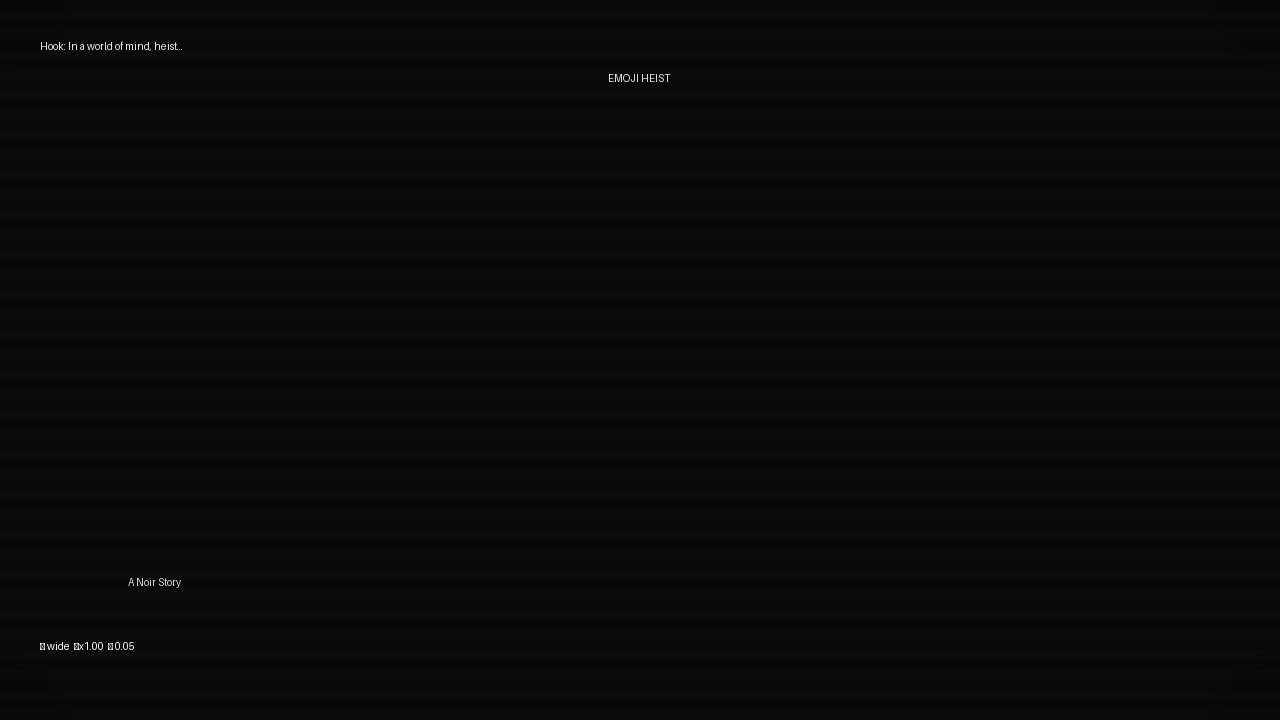

In [10]:

from IPython.display import Video, Image as IPyImage, display

# === Params ===
TITLE = "EMOJI HEIST"
EMOJIS = "🧠💎🕶️🚗💥🎭🌃"
STYLE = "noir"          # "anime" | "noir" | "vhs"
VERTICAL = False        # True → 9:16 crop for social

# === Pipeline ===
print(f"🎬 Title: {TITLE}")
print(f"😀 Emojis: {EMOJIS}")
print(f"🎨 Style: {STYLE}   📱 Vertical: {VERTICAL}")

emojis = [e for e in EMOJIS if not e.isspace()]
plan = generate_trailer_plan(TITLE, emojis, style=STYLE)
narration = " ".join([b.narration for b in plan.beats])

shots = compose_shots(plan)
frame_paths = generate_images(shots, Path('results/frames'))
print(f"🖼️ Generated {len(frame_paths)} frames → results/frames")

vo_path, alloc = synthesize_voice_gtts(narration, mp3_path="results/vo.mp3")
srt_path = build_captions_srt(alloc)
print(f"🔊 Voice: {vo_path} | ⏱ captions: {srt_path}")

mp4 = assemble_video(frame_paths, vo_path, alloc, vertical=VERTICAL, out_mp4="results/trailer.mp4")
print(f"🎞️ Trailer: {mp4}")

poster = make_poster(frame_paths[0], TITLE, f"A {STYLE.title()} Story", out="results/poster.png")
print(f"🖼️ Poster: {poster}")

display(Video(mp4, embed=True, html_attributes="controls preload"))
display(IPyImage(filename=poster))
